In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

In [7]:

FILES = ("/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets")
IMAGE_FILES = glob("/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets" + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))




Images Count:  15034


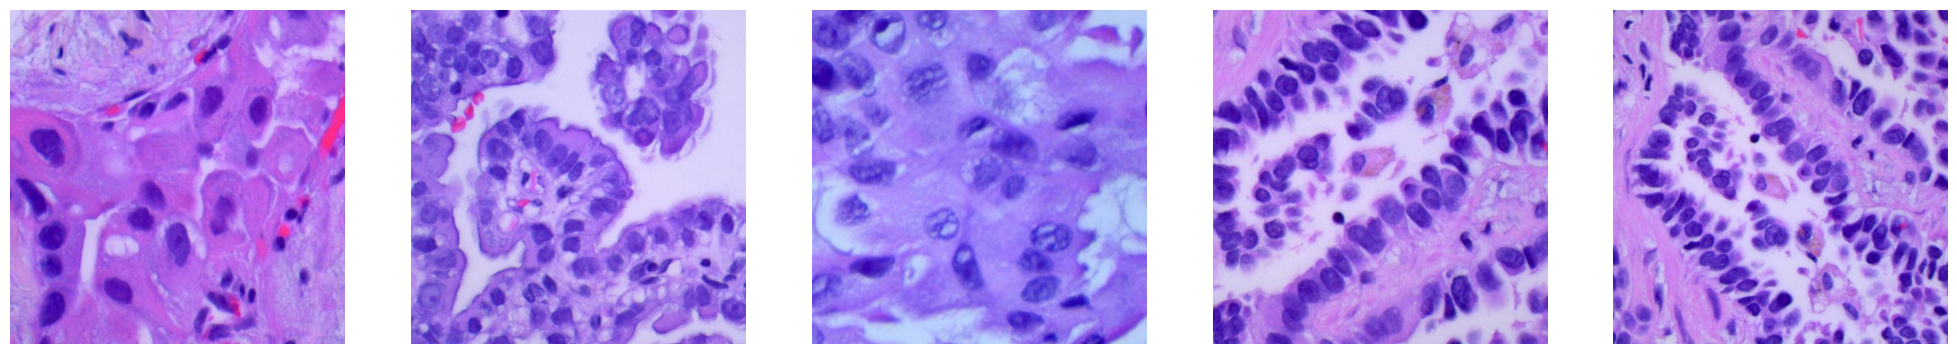

In [8]:
SAMPLES = ["/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1.jpeg",
           '/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca10.jpeg',
           '/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1000.jpeg',
           '/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1006.jpeg',
           '/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1007.jpeg']

plt.figure(figsize=(25, 10))
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

In [9]:
data_dir = "/content/drive/MyDrive/lung cancer data/lung_colon_image_set/lung_image_sets"

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 299
training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE,
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 12028 images belonging to 3 classes.
Found 3006 images belonging to 3 classes.


In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

In [11]:
IMG_SHAPE = (X,Y) +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [12]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [13]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 311
activation_93
mixed10


In [14]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(training))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 8, 8, 2048)


In [15]:
def ChestCancer_Model( image_shape=(X,Y)):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)

    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 290]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(3 ,activation = "softmax")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model


In [16]:
ChestCancer_Model = ChestCancer_Model((X,Y))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [17]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=15,
                          verbose=1,
                          restore_best_weights=True)

checkpoint=tf.keras.callbacks.ModelCheckpoint(
     './checkpoints',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    period=5
)
callback=[earlystop,checkpoint,tensorboard_callback]

In [18]:
import keras
base_learning_rate = 0.001
ChestCancer_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy' , tf.keras.metrics.Precision()])

In [19]:
history = ChestCancer_Model.fit(training , verbose=1 , epochs=3,
                               validation_data=validation , use_multiprocessing= True, callbacks=callback)

Epoch 1/3
94/94 [==============================] - 3746s 40s/step - loss: 0.7340 - accuracy: 0.8561 - precision: 0.8605 - val_loss: 0.2604 - val_accuracy: 0.8965 - val_precision: 0.8965
Epoch 2/3
94/94 [==============================] - 547s 6s/step - loss: 0.1265 - accuracy: 0.9491 - precision: 0.9491 - val_loss: 0.0874 - val_accuracy: 0.9691 - val_precision: 0.9691
Epoch 3/3
94/94 [==============================] - 517s 5s/step - loss: 0.0996 - accuracy: 0.9608 - precision: 0.9608 - val_loss: 0.1570 - val_accuracy: 0.9411 - val_precision: 0.9411


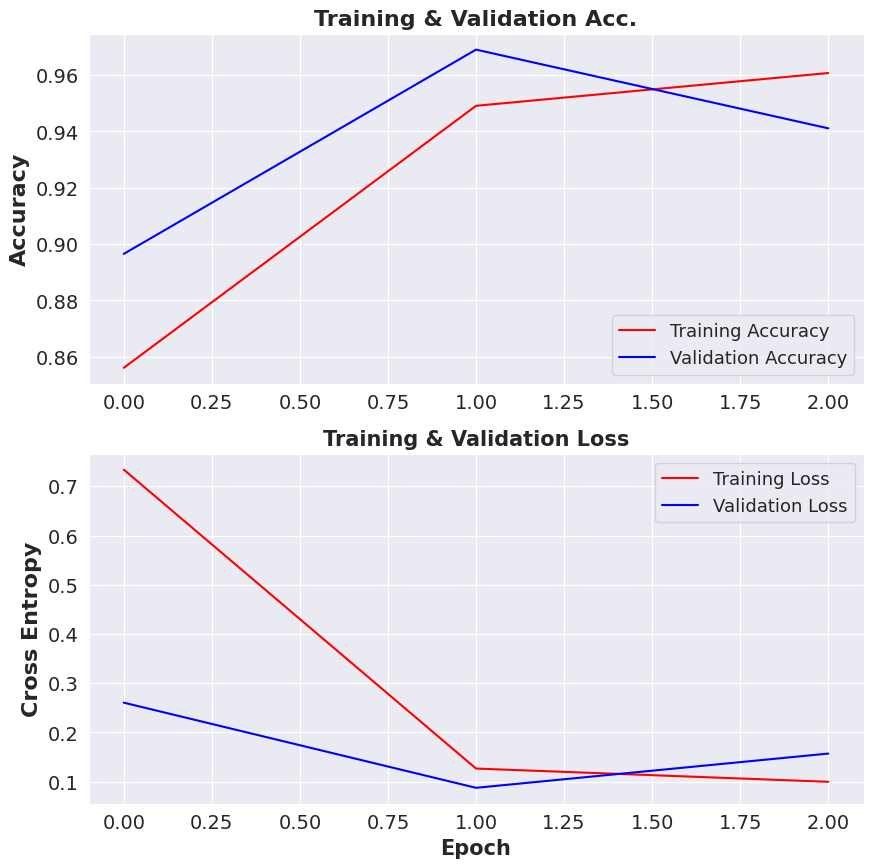

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [21]:
from sklearn.metrics import classification_report

Y_pred = ChestCancer_Model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

24/24 [==============================] - 38s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      1006
           1       1.00      1.00      1.00      1000
           2       0.85      1.00      0.92      1000

    accuracy                           0.94      3006
   macro avg       0.95      0.94      0.94      3006
weighted avg       0.95      0.94      0.94      3006



Normalized confusion matrix


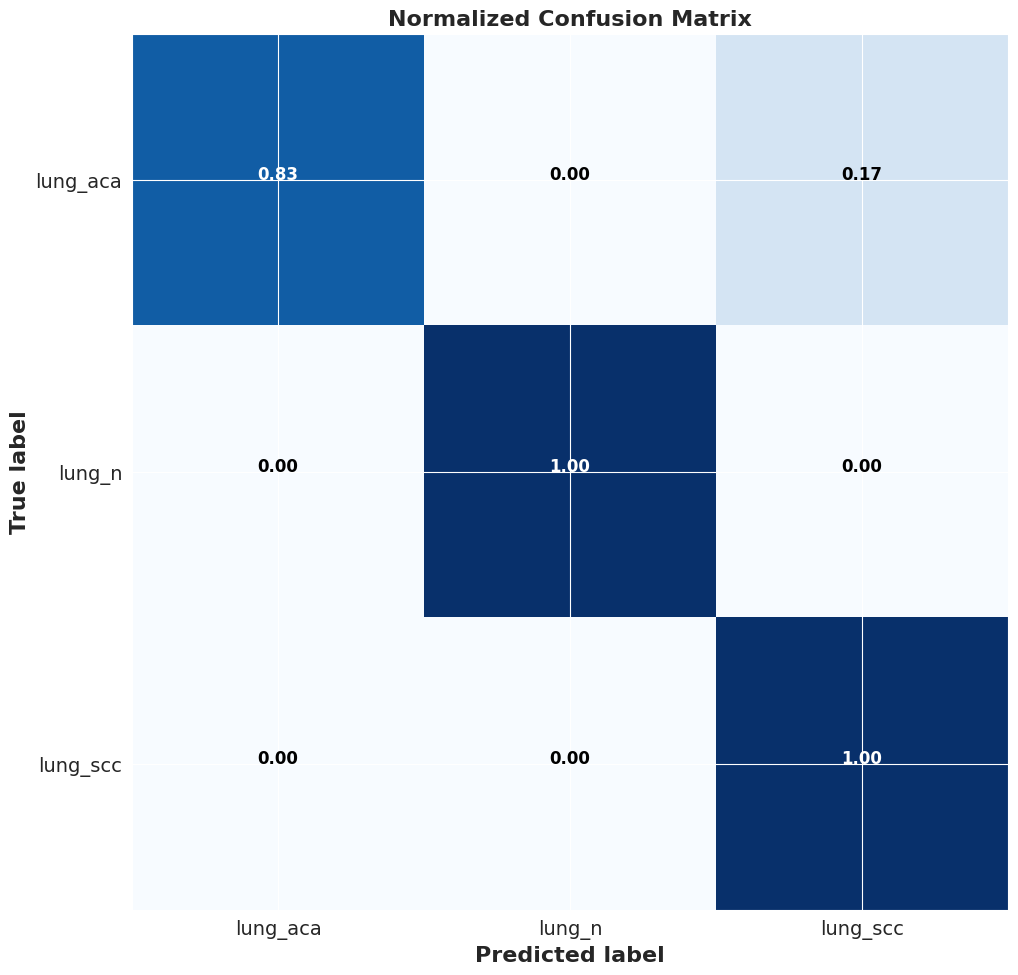

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()